# Section 1. Imports & Path


In [1]:
import os
from PIL import Image
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
DATASET_DIR = "../dataset/images"
DAY_DIR = os.path.join(DATASET_DIR, "day")
NIGHT_DIR = os.path.join(DATASET_DIR, "night")

# Section 2. Dataset Loading

- image loading
- X = images, y = labels
- label: day=0, night=1


In [22]:
def load_dataset():
    images = []
    labels = []
    paths = []

    for fname in sorted(os.listdir(DAY_DIR)):
        path = os.path.join(DAY_DIR, fname)
        if not os.path.isfile(path):
            continue  # skip if directory not file
        img = Image.open(path).convert("RGB")
        images.append(img)
        labels.append(0)  # day
        paths.append(path)

    for fname in sorted(os.listdir(NIGHT_DIR)):
        path = os.path.join(NIGHT_DIR, fname)
        if not os.path.isfile(path):
            continue  # skip if directory not file
        img = Image.open(path).convert("RGB")
        images.append(img)
        labels.append(1)  # night
        paths.append(path)

    return images, np.array(labels), paths

In [26]:
images, labels, paths = load_dataset()
print(f"Total images: {len(images)}, labels: {len(labels)}")

Total images: 60, labels: 60


# Section 3. Naïve Baseline

- RGB into grayscale
- average brightness > threshold: day
- if not, night


In [27]:
# computing brightness of an image
def compute_brightness(img: Image.Image):
    gray = img.convert("L")
    return np.array(gray).mean()

In [29]:
# threshold is set to 120
# return 0(day) if higher than threshold
def baseline_predict(images, threshold=120):
    preds = []
    for img in images:
        brightness = compute_brightness(img)
        preds.append(0 if brightness > threshold else 1)
    return np.array(preds)

In [30]:
# Baseline prediction eval
baseline_preds = baseline_predict(images)
baseline_acc = accuracy_score(labels, baseline_preds)

print(f"Baseline Accuracy: {baseline_acc:.3f}")

Baseline Accuracy: 0.617


# Section 4. AI Pipeline (CLIP)

- zero-shot inference using prompt


### Load Model


In [31]:
import torch
from transformers import CLIPProcessor, CLIPModel

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    use_safetensors=True
).to(device)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

print(device)

cuda


### Text Prompt


In [33]:
text_prompts = ["a photo taken during the day", "a photo taken at night"]

### Clip Prediction


In [34]:
def clip_predict(images, text_prompts):
    preds = []

    for img in images:
        inputs = processor(
            text=text_prompts,
            images=img,
            return_tensors="pt",
            padding=True
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits_per_image  # (1, 2)

        pred = logits.argmax(dim=1).item()
        preds.append(pred)

    return np.array(preds)

In [35]:
clip_preds = clip_predict(images, text_prompts)
clip_acc = accuracy_score(labels, clip_preds)

print(f"CLIP Accuracy: {clip_acc:.3f}")

CLIP Accuracy: 0.967


# Section 5. Evaluation


In [36]:
print("=== Results ===")
print(f"Naïve Baseline Accuracy: {baseline_acc:.3f}")
print(f"CLIP Pipeline Accuracy: {clip_acc:.3f}")

=== Results ===
Naïve Baseline Accuracy: 0.617
CLIP Pipeline Accuracy: 0.967


# Section 6. Qualitative Examples

- img which baseline is wrong and CLIP got it correct


### Visualization


In [39]:
# label int to str
def label_to_str(x):
    return "Day" if x == 0 else "Night"

In [40]:
import matplotlib.pyplot as plt

def show_result(idx):
    img = images[idx]

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")

    title = (
        f"GT: {label_to_str(labels[idx])}\n"
        f"Baseline: {label_to_str(baseline_preds[idx])}\n"
        f"CLIP: {label_to_str(clip_preds[idx])}"
    )
    plt.title(title, fontsize=10)
    plt.show()

In [41]:
error_cases = []

for i in range(len(images)):
    if baseline_preds[i] != labels[i] and clip_preds[i] == labels[i]:
        error_cases.append(i)

print(f"Found {len(error_cases)} cases where baseline failed but CLIP succeeded.")

Found 21 cases where baseline failed but CLIP succeeded.


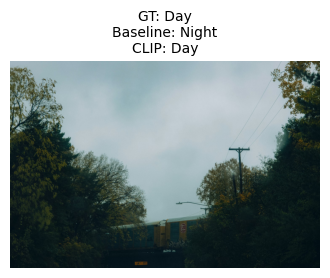

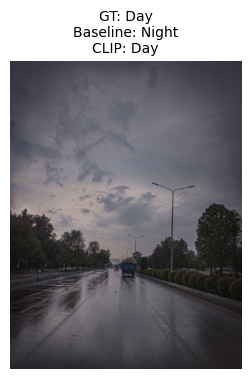

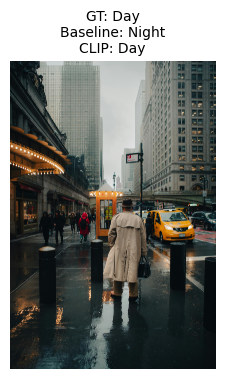

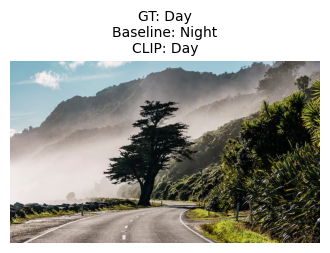

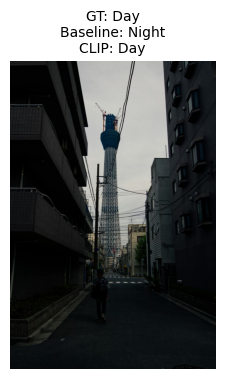

In [42]:
for idx in error_cases[:5]:
    show_result(idx)

### Limitations


In [43]:
clip_error_cases = []

for i in range(len(images)):
    if clip_preds[i] != labels[i]:
        clip_error_cases.append(i)

print(f"CLIP failed on {len(clip_error_cases)} images.")

CLIP failed on 2 images.


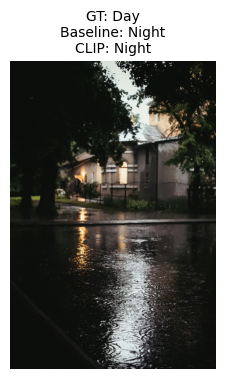

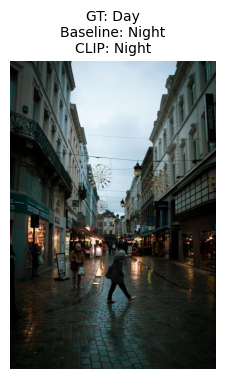

In [44]:
for idx in clip_error_cases[:3]:
    show_result(idx)